In [1]:
import pandas as pd 
from imblearn.over_sampling import SMOTENC, ADASYN, SMOTE
from imblearn.combine import  SMOTETomek, SMOTEENN
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier 

import numpy as np
import lightgbm as lgb
import optuna

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
RANDOM = 42
CV = 4

In [3]:
df_orders = pd.read_feather('/Users/aleksandrfilippov/practicum/practicum_env/1datasets/datasets/orders.feather')
df_prefered_teachers = pd.read_feather('/Users/aleksandrfilippov/practicum/practicum_env/1datasets/datasets/prefered_teachers_order_id.feather')
df_suitable_teachers = pd.read_feather('/Users/aleksandrfilippov/practicum/practicum_env/1datasets/datasets/suitable_teachers.feather')
df_teachers_info = pd.read_feather('/Users/aleksandrfilippov/practicum/practicum_env/1datasets/datasets/teachers_info.feather')

##  Подготовка df_orders
Весь процесс EDA оказался довольно обширным, в связи с этим в финальной версии только манипуляции с данными

In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

In [5]:
#Столбцы с возможными утечками
cols_to_drop = ['lesson_place', 
                'comments', 
                'prefered_teacher_id',
                'creator_id', 
                'additional_status_id',
                'max_metro_distance', 
                'payment_date', 
                'start_date', 
                'working_teacher_id', 
                'first_lesson_date',
                'home_metro_id',
                'amount_to_pay',
                'start_date',
                'comments',
                'estimated_fee',
                'first_lesson_date',
                'working_teacher_id',
                'additional_status_id',
                'prefered_teacher_id',
                'payment_date',
                'purpose',
                'add_info'
               ]
df_orders = df_orders.drop(cols_to_drop, axis = 1)

In [6]:
#Преобразуем таргет согласно тз
df_orders['status_id'] = df_orders['status_id'].apply(lambda x: 1 if x in [5, 6, 13, 15] else 0)

#Удалим аномальные значения
df_orders = df_orders[df_orders['subject_id'] < 1000]
df_orders = df_orders[df_orders['lesson_price'] < 10000]
df_orders = df_orders[df_orders['minimal_price'] < 20000]
df_orders.loc[df_orders['teacher_experience_to'] > 90, 'teacher_experience_to'] = 0
df_orders.loc[df_orders['teacher_age_from'] > 90, 'teacher_age_from'] = 0
df_orders.loc[(df_orders['teacher_age_to'] > 90) | (df_orders['teacher_age_to'] < 14), 'teacher_age_to'] = 0


#Преобразуем тип столбцов
df_orders['teacher_sex'] = df_orders['teacher_sex'].astype(str).replace('0', '3').astype(int)
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])

#Заполним пропуски
df_orders['pupil_category_new_id'] = df_orders['pupil_category_new_id'].fillna(0)

In [7]:
#Решаем проблему с дублями
df_orders.sort_values(by=['client_id', 'order_date'], inplace=True)
df_orders['original_order_id'] = df_orders.groupby('client_id')['original_order_id'].bfill()
df_orders['original_order_id'] = df_orders.groupby('client_id')['original_order_id'].ffill()
df_orders['original_order_id'] = df_orders['original_order_id'].fillna(df_orders['id'])
df_orders['new_status'] = df_orders.groupby('original_order_id')['status_id'].transform(lambda x: 1 if (x == 1).any() else 0)
df_orders.loc[df_orders['new_status'] == 1, 'status_id'] = 1

df_orders.drop('new_status', axis=1, inplace=True)

def replace_status(x):
    return 1 if (x == 1).sum() >= 7 else 0

df_orders['new_status'] = df_orders.groupby('client_id')['status_id'].transform(replace_status)
df_orders.loc[df_orders['new_status'] == 1, 'status_id'] = 1

#Создадим еще фичи и удалим не нужные столбцы
df_orders['order_day'] = df_orders['order_date'].dt.day
df_orders['order_month'] = df_orders['order_date'].dt.month
df_orders['order_hour'] = df_orders['order_date'].dt.hour
df_orders.drop(['new_status','order_date'], axis=1, inplace=True)

##  Подготовка df_teachers_info

In [8]:
df_teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

In [9]:
drop_cols = ['external_comments.1', 
             'lesson_duration.1',
             'lesson_cost.1', 
             'status_id.1', 
             'status_relevant_date.1', 
             'status_school_id.1', 
             'status_college_id.1', 
             'status_display.1', 
             'russian_level_id.1', 
             'home_country_id.1',
             'information.1', 
             'is_confirmed.1', 
             'external_comments.2', 
             'lesson_duration.2', 
             'lesson_cost.2', 
             'status_id.2', 
             'status_relevant_date.2', 
             'status_school_id.2', 
             'status_college_id.2', 
             'status_display.2', 
             'russian_level_id.2', 
             'home_country_id.2', 
             'photo_path', 
             'information.2', 
             'is_confirmed.2',
             'external_comments', 
             'status_relevant_date', 
             'status_school_id', 
             'status_college_id',
             'information', 
             'comments', 
             'last_visited', 
             'rules_confirmed_date', 
             'is_pupils_needed',
             'pupil_needed_date', 
             'remote_comments', 
             'passport_id', 
             'is_individual', 
             'partner_id', 
             'status_institution_id',
             'free_time_relevance_date',
             'date_update', 
             'relevance_date',
             'is_email_confirmed', 
             'is_cell_phone_confirmed', 
             'amount_to_pay'
            ]

df_teachers_info = df_teachers_info.drop(drop_cols, axis = 1)

In [10]:
#Преобразуем тип столбцов
df_teachers_info['reg_date'] = pd.to_datetime(df_teachers_info['reg_date'])
df_teachers_info['birth_date'] = pd.to_datetime(df_teachers_info['birth_date'])
df_teachers_info['teaching_start_date'] = pd.to_datetime(df_teachers_info['teaching_start_date'])
df_teachers_info.rename(columns = {'status_id': 'teacher_status_id'}, inplace = True)

#Удалим аномальные значения
df_teachers_info = df_teachers_info[df_teachers_info['birth_date'].dt.year > 1930]
df_teachers_info = df_teachers_info[df_teachers_info['teaching_start_date'].dt.year > 1970]
df_teachers_info.loc[df_teachers_info['lesson_duration'] > 240, 'lesson_duration'] = 240
df_teachers_info.loc[df_teachers_info['lesson_cost'] > 10000, 'lesson_cost'] = 10000


#Добавим новые фичи и удалим старые
df_teachers_info['reg_day'] = df_teachers_info['reg_date'].dt.day
df_teachers_info['reg_month'] = df_teachers_info['reg_date'].dt.month
df_teachers_info['reg_year'] = df_teachers_info['reg_date'].dt.year

df_teachers_info['birth_day'] = df_teachers_info['birth_date'].dt.day
df_teachers_info['birth_month'] = df_teachers_info['birth_date'].dt.month
df_teachers_info['birth_year'] = df_teachers_info['birth_date'].dt.year

df_teachers_info['ts_day'] = df_teachers_info['teaching_start_date'].dt.day
df_teachers_info['ts_month'] = df_teachers_info['teaching_start_date'].dt.month
df_teachers_info['ts_year'] = df_teachers_info['teaching_start_date'].dt.year

df_teachers_info.drop(['reg_date', 'birth_date', 'teaching_start_date'], axis = 1, inplace = True)

## Объединение всех данных и подготовка к обучению

In [11]:
#Соединяем данные из df_teachers_info и df_orders
merged_df = pd.merge(df_suitable_teachers, df_teachers_info, left_on='teacher_id', right_on='id', how='left')
merged_df = merged_df.groupby(by='order_id').agg('first')
final_df = pd.merge(merged_df, df_orders, left_on='order_id', right_on='id', how='left')

In [12]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842493 entries, 0 to 842492
Data columns (total 69 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   teacher_id                  842493 non-null  int32   
 1   contact_result              677127 non-null  category
 2   enable_auto_assign          842493 non-null  int8    
 3   enable_assign               842493 non-null  int8    
 4   id_x                        842301 non-null  float64 
 5   user_id                     842301 non-null  float64 
 6   is_home_lessons             842301 non-null  float64 
 7   is_external_lessons         842301 non-null  float64 
 8   lesson_duration_x           842301 non-null  float64 
 9   lesson_cost                 842301 non-null  float64 
 10  teacher_status_id           842301 non-null  float64 
 11  status_display              842301 non-null  float64 
 12  russian_level_id            842301 non-null  float64 
 13 

In [13]:
final_df.drop(['id_x', 'id_y', 'contact_result'], axis = 1, inplace = True)
final_df.dropna(inplace = True)
final_df.reset_index(drop=True, inplace=True)

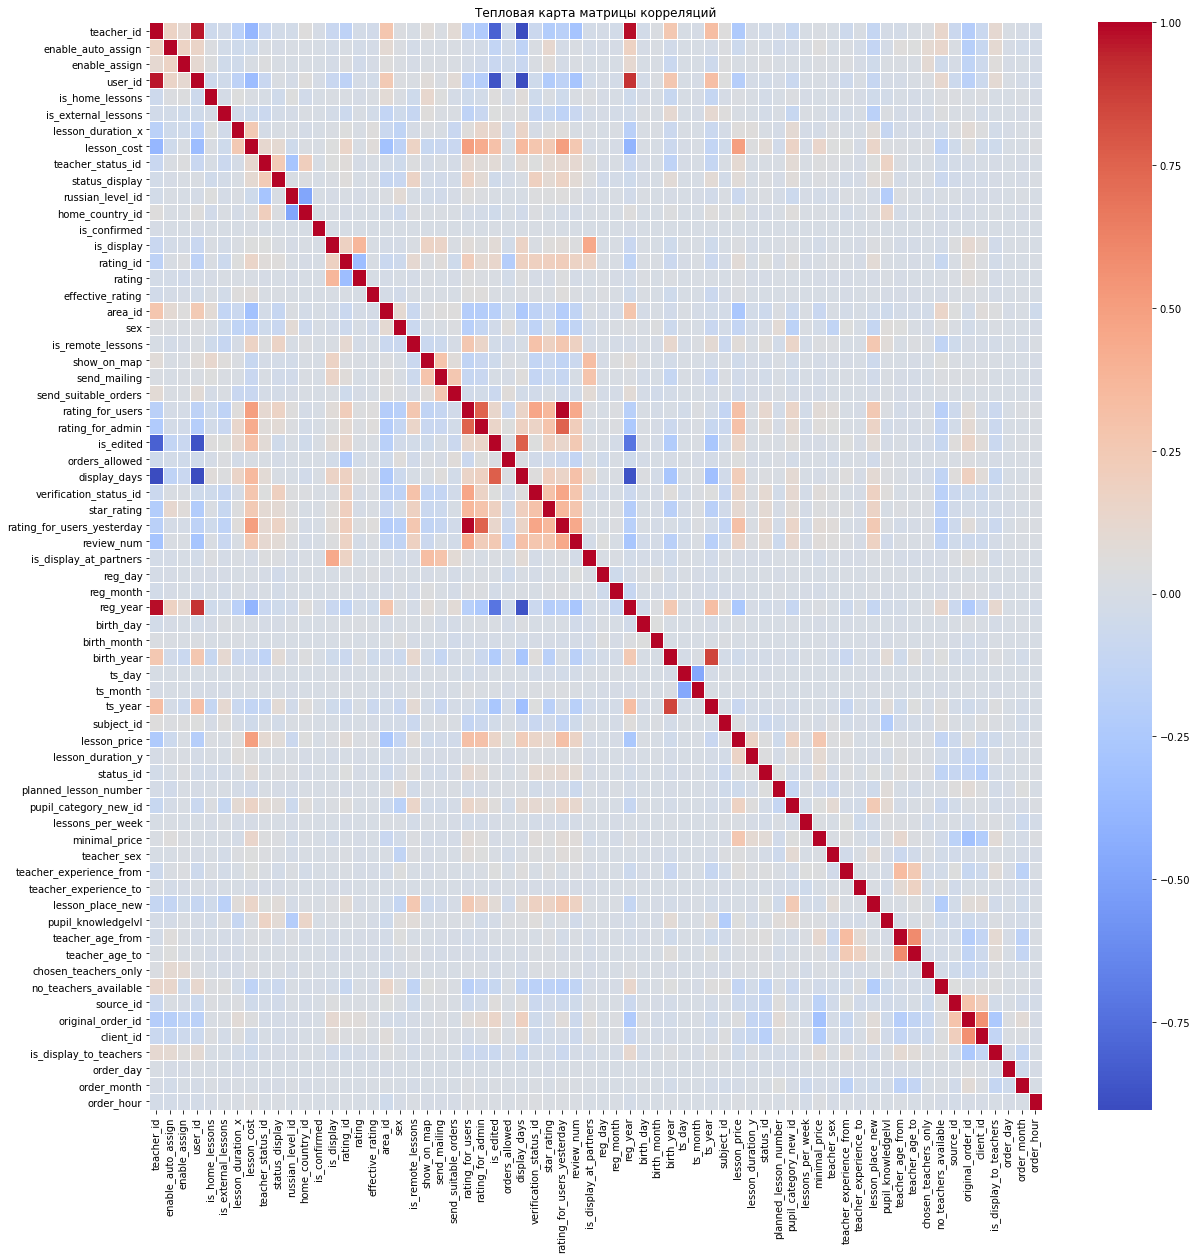

In [14]:
correlation_matrix = final_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Тепловая карта матрицы корреляций')
plt.show()

In [15]:
#Удаляем коррелирующие признаки
corr_drop = ['teacher_id', 
             'user_id', 
             'original_order_id', 
             'rating_for_users_yesterday', 
             'enable_assign', 
             'enable_auto_assign', 
             'is_edited', 
             'display_days', 
            ]
final_df.drop(corr_drop, axis = 1, inplace = True)

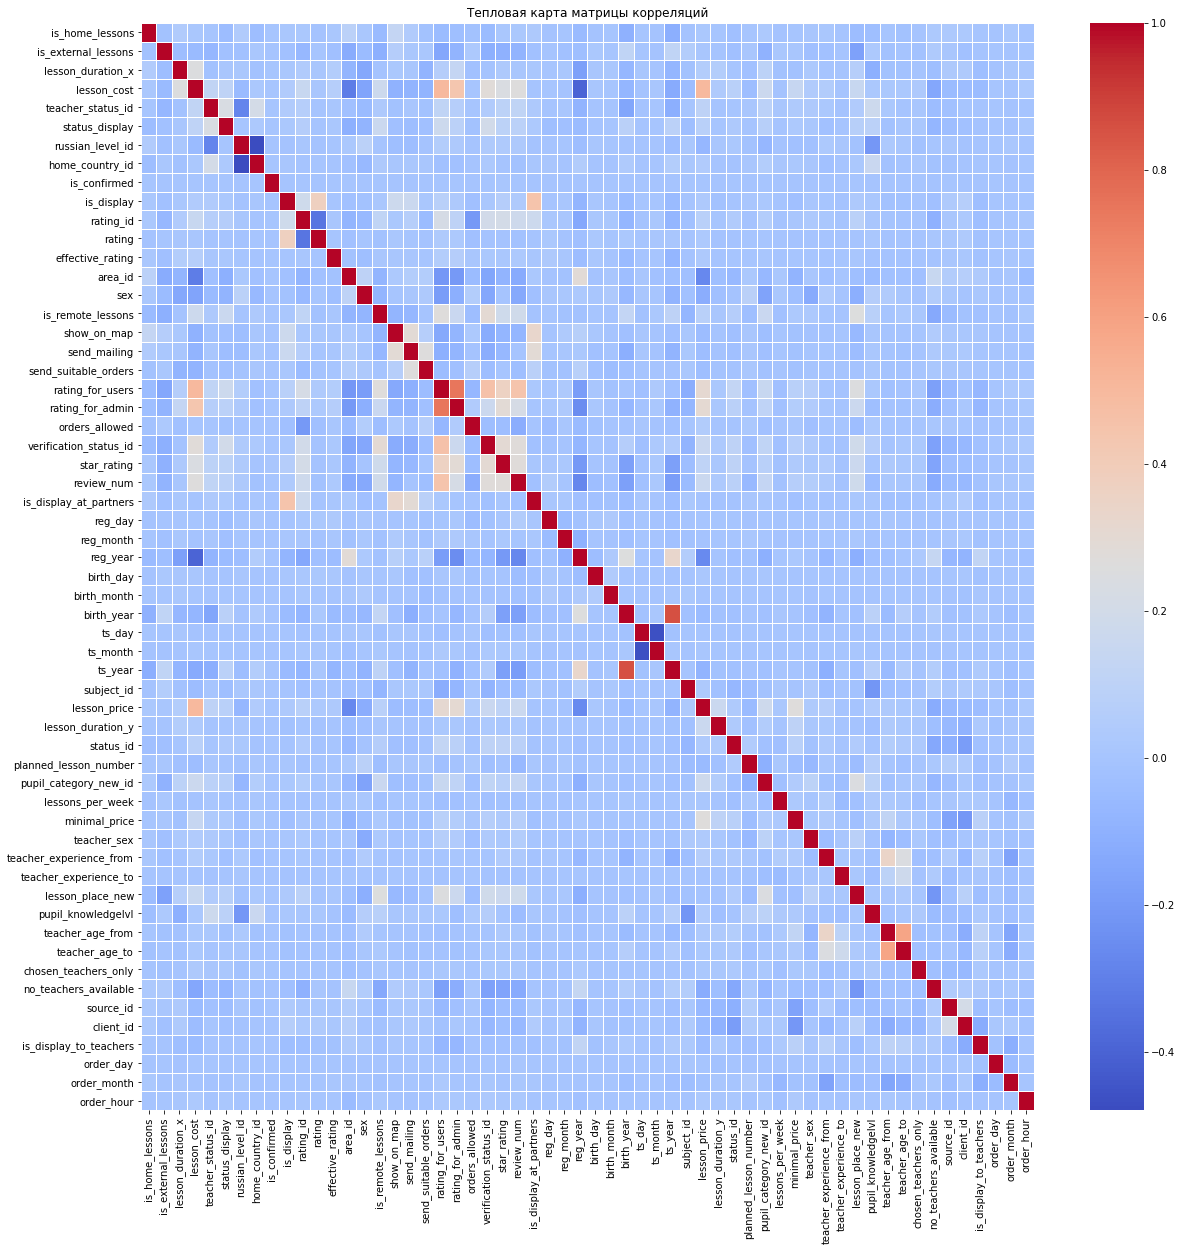

In [16]:
correlation_matrix = final_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Тепловая карта матрицы корреляций')
plt.show()

In [17]:
x = final_df.drop(['status_id'], axis=1)
y = final_df['status_id']

In [18]:
#Разбиваем на трейн/тест выборки
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=RANDOM, stratify=y)

In [19]:
#Избавляемся от дисбаланса классов, путем создания синтетических данных
smote = SMOTE(random_state=RANDOM)
x_train, y_train= smote.fit_resample(x_train, y_train)

In [20]:
#Масштабируем данные
scaler = StandardScaler()

columns_to_exclude = ['is_home_lessons', 'is_external_lessons', 'status_display', 'is_confirmed',\
                     'is_display', 'is_remote_lessons', 'show_on_map', 'send_mailing', 'send_suitable_orders', \
                     'orders_allowed', 'is_display_at_partners', 'chosen_teachers_only', 'no_teachers_available',\
                      'is_display_to_teachers']

x_train_to_scale = x_train.drop(columns=columns_to_exclude)
x_test_to_scale = x_test.drop(columns=columns_to_exclude)

scaled_x_train = scaler.fit_transform(x_train_to_scale)
scaled_x_test = scaler.transform(x_test_to_scale)

x_train_scaled = x_train.copy()
x_train_scaled[x_train_to_scale.columns] = scaled_x_train

x_test_scaled = x_test.copy()
x_test_scaled[x_test_to_scale.columns] = scaled_x_test

## LogisticRegression

In [21]:
model = LogisticRegression()

model.fit(x_train_scaled,y_train)

LogisticRegression()

In [22]:
def show_predict(xtest, ytest, model):
    '''
    Функция, которая принимает на вход тестовые данные, 
    а так же обученную модель. На выходе получается
    график ROC кривой, метрики модели и матрица ошибок
    '''
    y_pred_proba = model.predict_proba(xtest)[:, 1]

    fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
    roc_auc = roc_auc_score(ytest, y_pred_proba)


    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()


    y_pred = model.predict(xtest)
    print(classification_report(ytest, y_pred))

    cm = confusion_matrix(ytest, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]) 
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.show()

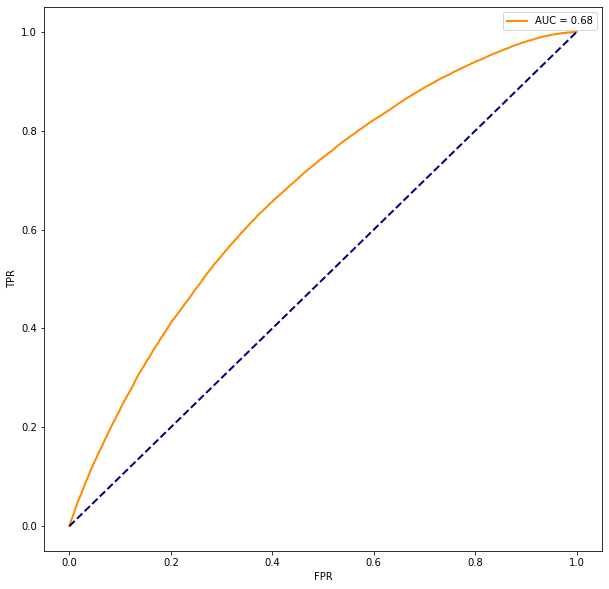

              precision    recall  f1-score   support

         0.0       0.77      0.61      0.68    110151
         1.0       0.46      0.65      0.54     56334

    accuracy                           0.62    166485
   macro avg       0.62      0.63      0.61    166485
weighted avg       0.67      0.62      0.63    166485



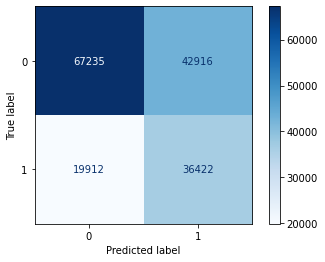

In [23]:
show_predict(x_test_scaled,y_test,model)

## LGBMClassifier

In [24]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model_lgb = lgb.LGBMClassifier(**params)
    model_lgb.fit(x_train_scaled, y_train)
    
    y_pred_proba = model_lgb.predict_proba(x_test_scaled)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc
   


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print('Параметры:', study.best_params)
opt_lgb_score = study.best_value
print('Precision LightGBM Classifier:', opt_lgb_score)

best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(x_train_scaled, y_train)

[I 2024-02-18 03:13:41,450] A new study created in memory with name: no-name-3cc51cd5-fd1b-493a-8265-ba199df86f66
[I 2024-02-18 03:13:52,963] Trial 0 finished with value: 0.726179498337068 and parameters: {'lambda_l1': 2.1940717125837192, 'lambda_l2': 8.24512142893668, 'num_leaves': 179, 'feature_fraction': 0.5537439654774354, 'bagging_fraction': 0.48495562818811655, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 0 with value: 0.726179498337068.
[I 2024-02-18 03:14:04,902] Trial 1 finished with value: 0.7293027452872309 and parameters: {'lambda_l1': 1.2339755782040571, 'lambda_l2': 7.829066411841438, 'num_leaves': 188, 'feature_fraction': 0.465830905957074, 'bagging_fraction': 0.7771385555533743, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 1 with value: 0.7293027452872309.
[I 2024-02-18 03:14:09,447] Trial 2 finished with value: 0.6953599249270364 and parameters: {'lambda_l1': 1.8097938796688913, 'lambda_l2': 9.448763194131612, 'num_leaves': 7, 'feature_fract

Параметры: {'lambda_l1': 3.0090389279311163, 'lambda_l2': 1.4664528100221594, 'num_leaves': 256, 'feature_fraction': 0.7896751927889303, 'bagging_fraction': 0.7910748251955684, 'bagging_freq': 1, 'min_child_samples': 85}
Precision LightGBM Classifier: 0.7358313755247066
[LightGBM] [Warning] lambda_l1 is set=3.0090389279311163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0090389279311163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7896751927889303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7896751927889303
[LightGBM] [Warning] bagging_fraction is set=0.7910748251955684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7910748251955684
[LightGBM] [Warning] lambda_l2 is set=1.4664528100221594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4664528100221594
[LightGBM] [Warning] lambda_l1 is set=3.0090389279311

LGBMClassifier(bagging_fraction=0.7910748251955684, bagging_freq=1,
               feature_fraction=0.7896751927889303,
               lambda_l1=3.0090389279311163, lambda_l2=1.4664528100221594,
               min_child_samples=85, num_leaves=256)

[LightGBM] [Warning] lambda_l1 is set=3.0090389279311163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0090389279311163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7896751927889303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7896751927889303
[LightGBM] [Warning] bagging_fraction is set=0.7910748251955684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7910748251955684
[LightGBM] [Warning] lambda_l2 is set=1.4664528100221594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4664528100221594


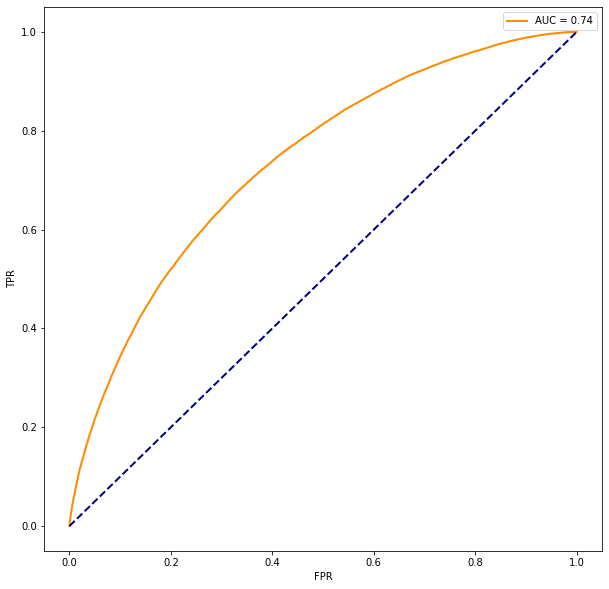

[LightGBM] [Warning] lambda_l1 is set=3.0090389279311163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0090389279311163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7896751927889303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7896751927889303
[LightGBM] [Warning] bagging_fraction is set=0.7910748251955684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7910748251955684
[LightGBM] [Warning] lambda_l2 is set=1.4664528100221594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4664528100221594
              precision    recall  f1-score   support

         0.0       0.74      0.88      0.80    110151
         1.0       0.62      0.39      0.48     56334

    accuracy                           0.71    166485
   macro avg       0.68      0.63      0.64    166485
weighted avg       0.70      0.71      0.69    16648

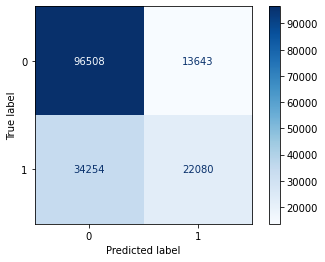

In [25]:
show_predict(x_test_scaled,y_test,final_model)

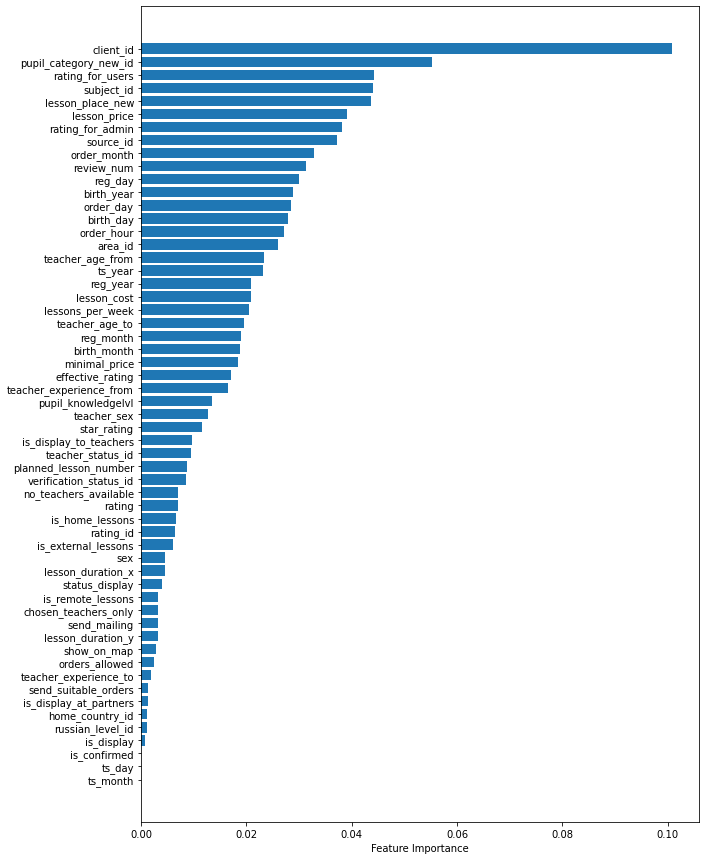

In [26]:
#Важность признаков
feature_importance = final_model.feature_importances_
feature_importance = feature_importance / feature_importance.sum()
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

## Выводы

В ходе проекта была подготовлена модель, которая по входным данным заявки определяет будет ли оплачена заявка или нет.

Проведена следующая работа:

- Проведен EDA, данные были подготовлены к обучению
- Были созданы две модели (LogisticRegression, LightGBMClassifier)
- Был выведен график важности признаков для лучшей модели (LightGBMClassifier с ```ROC_AUC = 0.74``` и ```precision = 0.62``` для 1 класса)

К сожалению лучшая модель не показала хороших цифр, так как более ```50%``` потенциальных покупателей останутся без внимания операторов, если слепо доверять модели. Так же важность признаков показала, что самым важным признаком оказался айди клиента, что не является самым лучшим критерием отбора клиентов для дальнейших звонков.

Из позитивных новостей, пользуясь моделью можно в 4 раза сократить нагрузку операторов